Multimission Simulation
-----------------------

This notebook demonstrates two analysis capabilities of the `grizli` software:

1. The capability of providing a reference image and SExtractor-like segmentation file created entirely independently from any given grism exposure.  The reference image is typically much deeper than a single direct image taken accompanying a grism exposure.  The code assumes that the grism file is astrometrically aligned to the reference image, but the reference image can have any pixel scale.

2. Simulation tools for comparison of slitless spectroscopy from a number of different space-based missions and instruments, notably *HST*/WFC3-IR, *JWST*/NIRISS, and the WFIRST wide-field instrument.

Here we take as an example the extremely deep WFC3 F140W imaging from the *Hubble* Ultra-Deep Field and processed by the ["eXtreme Deep Field"](http://xdf.ucolick.org/) project.  We use SExtractor (Bertin & Arnouts 1996) to detect objects in the deep image, creating a catlog and an accompanying segmentation image that defines which pixels are assigned to each object.

The second half of the notebook demonstrates how to use the `grizli.fake_image` scripts to create WFC3, NIRISS, and WFIRST-sized cutouts extracted from the deep reference image.  Those cutouts are then used as the reference to simulate slitless spectra from those instruments.

In [1]:
%matplotlib inline

In [2]:
import os

import matplotlib as mpl    
import matplotlib.pyplot as plt    
import matplotlib.gridspec
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np

import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from astropy.table import Table

import drizzlepac
import photutils

try:
    ## Local development environment
    import grizlidev as grizli
    import grizlidev.fake_image
    import grizlidev.version
    reload(grizli.model); reload(grizli.fake_image); reload(grizli.version); reload(grizli)
except:
    ## Use the public repo
    import grizli
    import grizli.fake_image

print '\n grizli version: %s' %(grizli.__version__)

The following tasks in the stwcs.gui package can be run with TEAL:
     apply_headerlet          archive_headerlet          attach_headerlet     
     delete_headerlet         extract_headerlet         headerlet_summary     
    restore_headerlet             updatewcs              write_headerlet


The following task in the fitsblender package can be run with TEAL:
                                  blendheaders                                  
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol

 grizli version: 0.1.1-42-g971e4aa


In [3]:
## Fetch the UDF images from the HLSP pages
if not os.path.exists('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits'):
    url = 'https://archive.stsci.edu/missions/hlsp/xdf/'
    os.system('wget %s/hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits' %(url))
    os.system('wget %s/hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_wht.fits' %(url))

## Make SExtractor catalog
if not os.path.exists('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits'):
    os.system('wget http://www.stsci.edu/~brammer/grism/grizli_xdf_sextractor.tar.gz')
    os.system('tar xzvf grizli_xdf_sextractor.tar.gz')

    os.system('sex hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits ' + 
              '-c hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1.sex')

## Need a WFC3 FLT file later
if not os.path.exists('ibhj34h6q_flt.fits'):
    os.system('wget http://www.stsci.edu/~brammer/grism/grizli_demo_data.tar.gz')
    os.system('tar xzvf grizli_demo_data.tar.gz')

In [4]:
## Initialize the Grizli object, flt_file is the G141 exposure
pad=120 # allow simulation of objects at the edges
flt = grizli.model.GrismFLT(grism_file='ibhj34h8q_flt.fits', verbose=True, pad=pad,  
                            ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits', 
                            seg_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits')

Segmentation cutout: x=slice(509, 4977, None), y=slice(882, 5250, None) [Out of range]
ibhj34h8q_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Segmentation cutout: x=slice(509, 4977, None), y=slice(882, 5250, None) [Out of range]
ibhj34h8q_flt.fits / blot segmentation hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits[0]


The `pad` keyword above is used to extract a cutout from the reference image that is larger than the direct image itself so that objects can be accounted for and modeled that would otherwise "fall off" of the direct image but whose dispersed spectra fall on the grism images.  The figure below compares the direct image itself to the "blotted" reference image that contains an extra border of pixels around the edges.

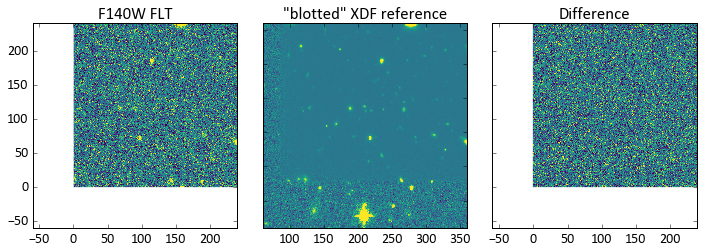

In [5]:
## Show the blotted reference direct image
f140w = pyfits.open('ibhj34h6q_flt.fits')
fig = plt.figure()

ax = fig.add_subplot(131) # FLT exposure
ax.imshow(f140w['SCI'].data, interpolation='Nearest', 
           origin='lower', vmin=-0.2, vmax=0.3, cmap='viridis')
ax.set_title('F140W FLT')

ax = fig.add_subplot(132) # Blotted reference image
blotted = flt.direct.data['REF']/flt.direct.ref_photflam
ax.imshow(blotted, interpolation='Nearest', 
           origin='lower', vmin=-0.2, vmax=0.3, cmap='viridis')
ax.set_title('"blotted" XDF reference')

ax = fig.add_subplot(133) # Grism
ax.imshow(f140w['SCI'].data - blotted[pad:-pad, pad:-pad],
           interpolation='Nearest', 
           origin='lower', vmin=-0.2, vmax=0.3, cmap='viridis')
ax.set_title('Difference')

for ax in fig.axes[1:]:
    ax.set_yticklabels([])

for i, ax in enumerate(fig.axes):
    offset = (i != 1)*pad # First is (1014,1014), others are (1014+2*pad, 1014+2*pad)
    ax.set_xlim(60-offset,360-offset)
    ax.set_ylim(60-offset,360-offset)

fig.tight_layout()

Since the grism configuration files are all defined in detector coordinates, the `blot_catalog` function is used to compute the detector positions of the objects detected in the rectified reference image.

In [6]:
## "blotted" SExtractor catalog, with catalog sky coordinates put into FLT frame
ref_cat = Table.read(pyfits.open('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.cat')[2])
flt_cat = flt.blot_catalog(ref_cat, sextractor=True) # also stored in flt.catalog

In [7]:
## Compute flat-spectrum model of bright sources
mask = flt_cat['MAG_AUTO'] < 27
print 'N=%d' %(mask.sum())
#flt.compute_full_model(compute_beams=['A','B','C','D','E','F'], mask=mask, verbose=False)
flt.compute_full_model(ids=flt_cat['NUMBER'][mask], mags=flt_cat['MAG_AUTO'][mask])

N=1995


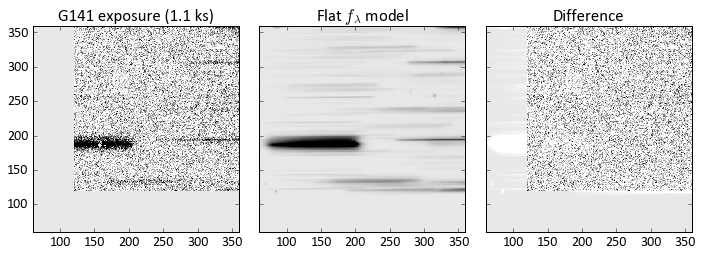

In [8]:
# Compare to the actual G141 exposure
fig = plt.figure()

ax = fig.add_subplot(131)
ax.imshow(flt.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')
ax.set_title('G141 exposure (1.1 ks)')

ax = fig.add_subplot(132)
ax.imshow(flt.model, interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')
ax.set_title(r'Flat $f_\lambda$ model')

ax = fig.add_subplot(133)
ax.imshow(flt.grism.data['SCI'] - flt.model, interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')
ax.set_title('Difference')

for ax in fig.axes[1:]:
    ax.set_yticklabels([])

# show lower corner and how objects are modeled right to the edge
for ax in fig.axes:
    ax.set_xlim(60,360)
    ax.set_ylim(60,360)

fig.tight_layout()

The bright spectrum at lower left and the fainter spectrum at the top would not be modeled if just the single direct image were available.  However, they are included in the "padded" reference image and even the simple flat-spectrum model offers a reasonable first guess at the grism exposure model.

Slitless spectra from multi-missions *JWST*/NIRISS and *WFIRST*
---------------------------------------------------------------

The examples below show how to first generate a "dummy" cutout image from the reference image, where the image itself is not cutout but rather the dummy images have appropriate WCS so that the `grizli.model.GrismFLT` will then be able to blot the reference and segmentation images.  

The image headers specify default values of the per-pixel sky backgrounds that are adopted with `make_fake_image(background='auto')`, that parameter can also be set to any desired float value.  The `make_fake_image` generating script has parameters `exptime` and `nexp` that are the used to define a simple noise model for the resulting simulation.  

$\sigma^2 = \mathrm{sky}\cdot\mathrm{exptime} + N_\mathrm{exp}\cdot\mathrm{readnoise}$

The value of $\sigma$ is stored in the `ERR` extension and random Gaussian deviates are put into the `SCI` extension of the `output` FITS files that are useful later for adding noise to the noiseless simulated spectra.

Again, these examples simulate grism exposures from the different missions/instruments with simple flat-spectrum SEDs with normalization set by the UDF F140W image (at 1.4 µm).  However, it is straightforward to use *any* spectrum (i.e., stellar or galaxy templates) for any given object model.

In [9]:
### Fake images, cendered in the UDF/XDF
ra, dec = 53.1592277508136, -27.782056346146
pa_aper = 128.589

# allow simulation of objects at the edges
pad=0 # pixels

mag_limit = 25 # faint limit for the simulation
np.random.seed(1)
EXPTIME = 1.e4 # 10 ks ~ 4 HST orbits
NEXP = 10      # divided between 10 exposures

In [10]:
### WFC3/IR G141
h, wcs = grizli.fake_image.wfc3ir_header(filter='G141', ra=ra, dec=dec, pa_aper=pa_aper,
                                         flt='ibhj34h6q_flt.fits')
grizli.fake_image.make_fake_image(h, output='wfc3ir.fits', exptime=EXPTIME, nexp=NEXP)

wfc3 = grizli.model.GrismFLT(grism_file='wfc3ir.fits', verbose=True, pad=pad,  
                           ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits', 
                           seg_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits')

wfc3_cat = wfc3.blot_catalog(ref_cat, sextractor=True) # also stored in flt.catalog
wfc3.catalog = wfc3_cat

mask = wfc3_cat['MAG_AUTO'] < mag_limit
print 'N=%d' %(mask.sum())
#wfc3.compute_full_model(compute_beams=['A','B','C','D','E','F'], mask=mask, verbose=False)
wfc3.compute_full_model(ids=wfc3_cat['NUMBER'][mask], mags=wfc3_cat['MAG_AUTO'][mask])

Segmentation cutout: x=slice(1255, 4287, None), y=slice(1633, 4693, None)
wfc3ir.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Segmentation cutout: x=slice(1255, 4287, None), y=slice(1633, 4693, None)
wfc3ir.fits / blot segmentation hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits[0]
N=432
ID 228 not found in segmentation image
ID 1504 not found in segmentation image


In [11]:
### JWST NIRISS
h, wcs = grizli.fake_image.niriss_header(filter='F150W', ra=ra, dec=dec, pa_aper=pa_aper)
grizli.fake_image.make_fake_image(h, output='niriss.fits', exptime=EXPTIME, nexp=NEXP)

niriss = grizli.model.GrismFLT(grism_file='niriss.fits', verbose=True, pad=pad,  
                           ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits', 
                           seg_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits')

niriss_cat = niriss.blot_catalog(ref_cat, sextractor=True) # also stored in flt.catalog
niriss.catalog = niriss_cat

mask = niriss_cat['MAG_AUTO'] < mag_limit
print 'N=%d' %(mask.sum())
#niriss.compute_full_model(compute_beams=['A','B','C','D','E'], mask=mask, verbose=False)
niriss.compute_full_model(ids=niriss_cat['NUMBER'][mask], mags=niriss_cat['MAG_AUTO'][mask])

Segmentation cutout: x=slice(1223, 4369, None), y=slice(1612, 4760, None)
niriss.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Segmentation cutout: x=slice(1223, 4369, None), y=slice(1612, 4760, None)
niriss.fits / blot segmentation hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits[0]
N=477


In [12]:
### WFIRST GRS grism
h, wcs = grizli.fake_image.wfirst_header(ra=ra, dec=dec, pa_aper=pa_aper, naxis=(1180,1180))
grizli.fake_image.make_fake_image(h, output='wfirst.fits', exptime=EXPTIME, nexp=NEXP)

wfirst = grizli.model.GrismFLT(grism_file='wfirst.fits', verbose=True, pad=pad,  
                               ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits', 
                               seg_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits')

wfirst_cat = wfirst.blot_catalog(ref_cat, sextractor=True) 
wfirst.catalog = wfirst_cat

mask = wfirst_cat['MAG_AUTO'] < mag_limit
print 'N=%d' %(mask.sum())
#wfirst.compute_full_model(compute_beams=['A'], mask=mask, verbose=False)
wfirst.compute_full_model(ids=wfirst_cat['NUMBER'][mask], mags=wfirst_cat['MAG_AUTO'][mask])

Segmentation cutout: x=slice(1275, 4315, None), y=slice(1666, 4706, None)
wfirst.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Segmentation cutout: x=slice(1275, 4315, None), y=slice(1666, 4706, None)
wfirst.fits / blot segmentation hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits[0]
N=455
ID 301 not found in segmentation image
ID 791 not found in segmentation image


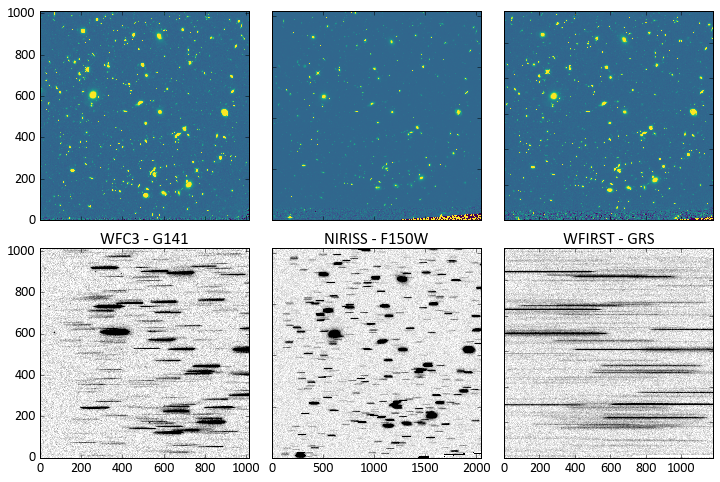

In [13]:
### Show them!
# Compare to the actual G141 exposure
fig = plt.figure(figsize=[10,10.*2/3])

for i, sim in zip([0,1,2], [wfc3, niriss, wfirst]):
    # Direct
    axt = fig.add_subplot(231+i)
    axt.imshow(sim.direct.data['REF']/sim.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.1, vmax=0.2, cmap='viridis')
    axt.set_xticklabels([])
    
    # Grism
    axb = fig.add_subplot(234+i)
    axb.imshow(sim.model + sim.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')
    axb.set_title('%s - %s' %(sim.grism.instrument, sim.grism.filter))
    
    if i > 0:
        axt.set_yticklabels([])
        axb.set_yticklabels([])

fig.tight_layout(pad=0.5)

The NIRISS spectra with the blocking filters take up much less detector real estate than the WFC3/G141 and (especially) the WFIRST spectra.

Pull out an object and simulate a spectrum with lines
-----------------------------------------------------

As in the other demonstration notebooks, we now show how to "extract" a single object spectrum and compute a more detailed spectral model for that object, in this case a young star-forming galaxy with strong emission lines.

In [14]:
## Find the object ID near coordinates (r0,d0), 
## SExtractor IDs might not be constant across platforms
r0, d0 = 53.159868, -27.785791
r0, d0 = 53.160473, -27.786294 # H~23, works well
#r0, d0 = 53.155611, -27.779308 # bright
dr = np.sqrt((ref_cat['X_WORLD']-r0)**2*np.cos(d0/180*np.pi)**2 + 
             (ref_cat['Y_WORLD']-d0)**2)*3600
id = ref_cat['NUMBER'][np.argmin(dr)]
obj_mag = ref_cat['MAG_AUTO'][np.argmin(dr)]
print 'ID:%d, mag=%.2f' %(id, obj_mag)

beams = {}
reload(grizli.model)

for i, sim in zip([0,1,2], [wfc3, niriss, wfirst]):
    print sim.direct.instrument
    ix = sim.catalog['id'] == id
    #x0, y0 = sim.catalog['x_flt'][ix][0], sim.catalog['y_flt'][ix][0]
    #dim = 18*0.135/sim.flt_wcs.pscale 
    #beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, 
    #                               cutout_dimensions=np.cast[int]((dim, dim)), 
    #                               conf=sim.conf, GrismFLT=sim)
    
    cutout = grizli.model.BeamCutout(sim, sim.object_dispersers[id]['A']) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(sim.model)
    if id in sim.object_dispersers:
        cutout.contam -= cutout.beam.model
    
    beams[sim.grism.instrument] = cutout

ID:4743, mag=23.73
WFC3
NIRISS
WFIRST


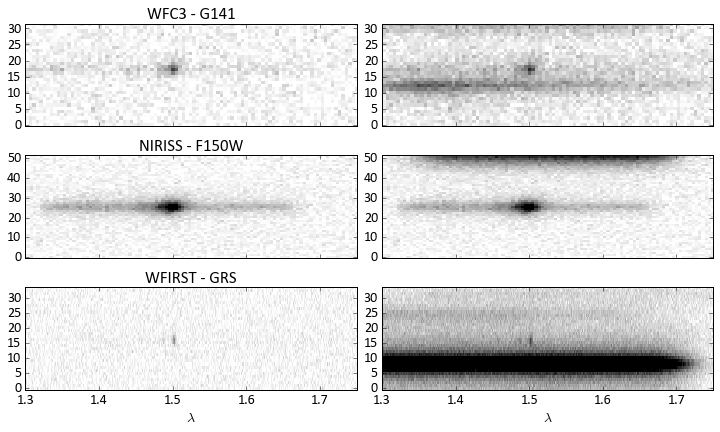

In [15]:
## Spectrum with lines & noise
spectrum_file = os.path.join(os.path.dirname(grizli.__file__), 'data/erb2010.dat')
erb = np.loadtxt(spectrum_file, unpack=True)
z = 2.0 # test redshift

## normalize spectrum to unity to use normalization defined in the direct image
import pysynphot as S
spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
spec = spec.redshift(z).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f140w'))

fig = plt.figure()
for i, key in enumerate(beams.keys()):
    #     beams[key].compute_model(beams[key].thumb, id=beams[key].id, 
    #                              xspec=spec.wave, yspec=spec.flux)
    beams[key].beam.compute_model(spectrum_1d=[spec.wave, spec.flux]) 
    
    axl = fig.add_subplot(321+i*2)
    axl.imshow(beams[key].model + beams[key].grism.data['SCI']*1, interpolation='Nearest', 
           origin='lower', vmin=-0.006, vmax=0.16, cmap='gray_r', aspect='auto')
    
    axr = fig.add_subplot(321+i*2+1)
    axr.imshow(beams[key].contam + beams[key].grism.data['SCI'] + beams[key].model, 
               interpolation='Nearest', 
               origin='lower', vmin=-0.006, vmax=0.16, cmap='gray_r', aspect='auto')
    
    axl.set_title('%s - %s' %(key, beams[key].grism.filter))
    for ax in [axl, axr]:
        beams[key].twod_axis_labels(wscale=1.e4, mpl_axis=ax)
        beams[key].twod_xlim(1.3,1.75, wscale=1.e4, mpl_axis=ax)
        if i < 2:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(r'$\lambda$')

fig.tight_layout(pad=0.5)

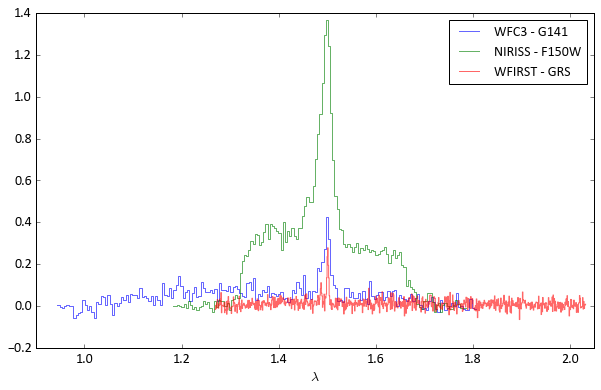

In [16]:
### Plot 1D spectra
for i, key in enumerate(beams.keys()):
    w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    plt.plot(w/1.e4, f, label='%s - %s' %(key, beams[key].grism.filter), 
             alpha=0.6, linestyle='steps-mid')

plt.legend(fontsize=14)
plt.xlim(0.9, 2.05)
plt.xlabel(r'$\lambda$')

The differences between the properties of the slitless spectra from the various instruments/telescopes are dramatic.  With the large telescope aperture, the NIRISS spectrum is clearly the highest S/N in both the line and continuum, though at quite low spectral resolution.  In practice the effective NIRISS spectral resolution may be a bit better than this simulation would suggest, where the object morphology is barely, if at all, resolved at *HST* resolution.

The G141 and WFIRST spectra show similar count rates in the line, but at high spectral resolution the WFIRST continuum is essentially lost (at native resolution).  Though with the huge spectra the WFIRST contamination can be problematic, the [OIII] and H$\beta$ lines are nicely resolved and poke out above the smooth continuum.